# Project Galilei
### "Measure what is measurable, and make measurable what is not so."

## Topic Modeling Abstract

    imports

In [1]:
import pickle

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import re

import missingno as msno

# https://course.spacy.io/en/
from nltk.corpus import stopwords
import spacy
from spacy.lang import en
from spacy import load, displacy

import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import preprocess_documents
from gensim.models import CoherenceModel, Doc2Vec, LdaModel
import pyLDAvis
import pyLDAvis.gensim_models

from modules.preprocessing import free_form_preprocessor, free_form_counter, lemmings

from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

    read

In [2]:
arxiv_meta = pd.read_json("../data/raw/arxiv-metadata-oai-snapshot.json", lines=True, nrows=10000)

In [3]:
arxiv_meta.head(5)

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


    EDA

C:\Users\mjwjl\anaconda3\lib\site-packages\missingno\missingno.py:72: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax0.grid(b=False)
C:\Users\mjwjl\anaconda3\lib\site-packages\missingno\missingno.py:141: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax1.grid(b=False)


<AxesSubplot:>

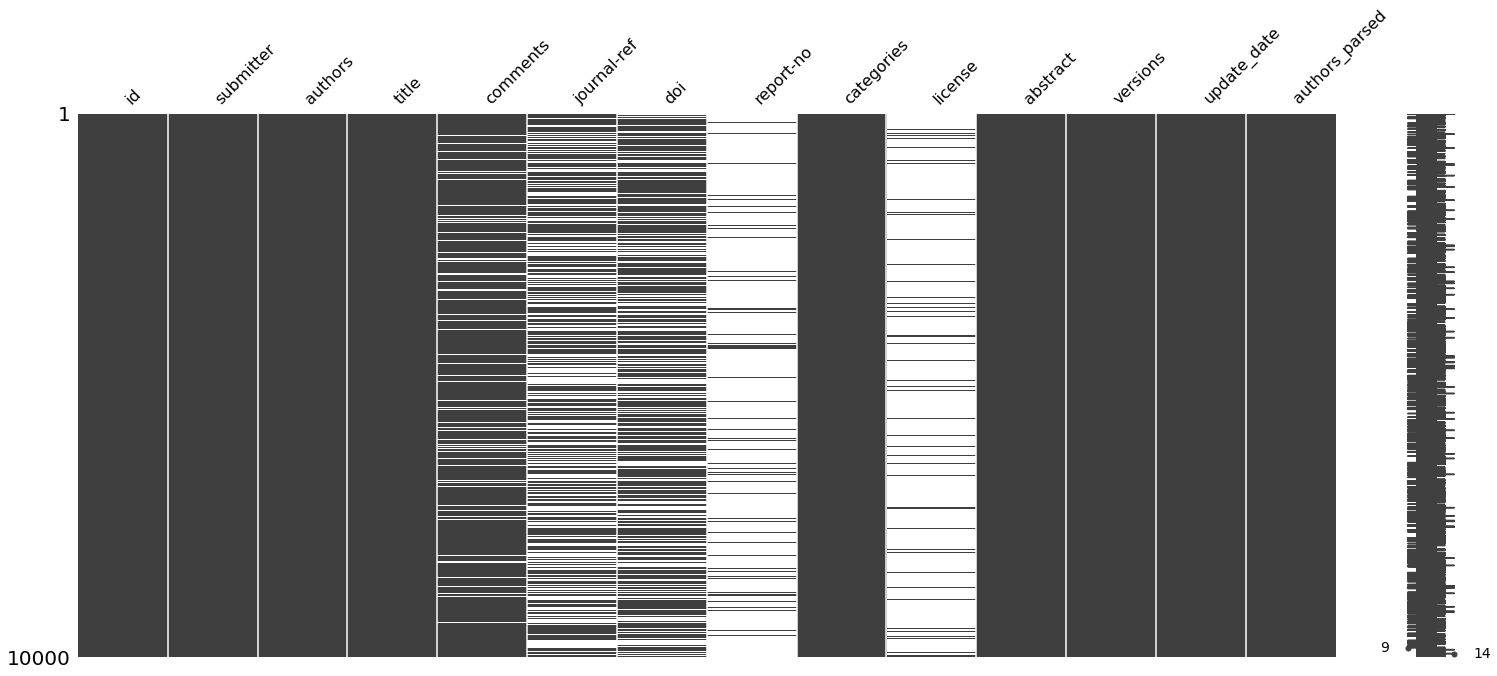

In [4]:
msno.matrix(arxiv_meta)

Features are full rank for all columns relevant. 

In [5]:
arxiv_meta["categories"].value_counts(normalize=True).head(20)

astro-ph              0.1719
hep-ph                0.0475
quant-ph              0.0466
hep-th                0.0427
gr-qc                 0.0218
cond-mat.mtrl-sci     0.0194
cond-mat.mes-hall     0.0179
cond-mat.str-el       0.0164
cond-mat.stat-mech    0.0145
nucl-th               0.0141
hep-ex                0.0139
math.AG               0.0116
math-ph math.MP       0.0110
cond-mat.other        0.0108
cs.IT math.IT         0.0106
math.PR               0.0098
physics.gen-ph        0.0092
cond-mat.soft         0.0091
nucl-ex               0.0089
cond-mat.supr-con     0.0086
Name: categories, dtype: float64

Remarkable representation of many of these tags as topics, even if unlabeled.

In [6]:
arxiv_meta["update_date"].sort_values()

4999    2007-05-23
2717    2007-05-23
6595    2007-05-23
6589    2007-05-23
6582    2007-05-23
           ...    
8708    2021-08-23
5877    2021-08-30
8062    2021-10-14
274     2021-10-15
3247    2021-11-15
Name: update_date, Length: 10000, dtype: object

Data extends from 2007 - 2021. After submission I will stream data from json 

    process

In [7]:
# grab set of stopwords from nltk and CV
sw = set(stopwords.words("english"))
cv = set(CountVectorizer(stop_words="english").get_stop_words())

# union of stopwrods from nltk and CV extended with custom stopwords
stops = list(set(cv | sw))
stops.extend(["php", "k", "ell", "n", "r", "t", "bf", "pi"])

In [8]:
arxiv_meta["abstract"][1]

'  We describe a new algorithm, the $(k,\\ell)$-pebble game with colors, and use\nit obtain a characterization of the family of $(k,\\ell)$-sparse graphs and\nalgorithmic solutions to a family of problems concerning tree decompositions of\ngraphs. Special instances of sparse graphs appear in rigidity theory and have\nreceived increased attention in recent years. In particular, our colored\npebbles generalize and strengthen the previous results of Lee and Streinu and\ngive a new proof of the Tutte-Nash-Williams characterization of arboricity. We\nalso present a new decomposition that certifies sparsity based on the\n$(k,\\ell)$-pebble game with colors. Our work also exposes connections between\npebble game algorithms and previous sparse graph algorithms by Gabow, Gabow and\nWestermann and Hendrickson.\n'

TeX and Markdown formulas are frequent throughout. Ideally they would be retained, even if not human readable they are unique tokens. While many candidates for stop words identified downstream $\pi$ was often the most salient term across most topics.

In [9]:
arxiv_meta["abstract_processed_text"] = free_form_preprocessor(arxiv_meta, "abstract", stops)

In [10]:
arxiv_meta["abstract_processed_text"][1]

'new algorithm pebble game colors use obtain characterization family sparse graphs algorithmic solutions family problems concerning tree decompositions graphs special instances sparse graphs appear rigidity theory received increased attention recent years particular colored pebbles generalize strengthen previous results lee streinu new proof tutte nash williams characterization arboricity present new decomposition certifies sparsity based pebble game colors work exposes connections pebble game algorithms previous sparse graph algorithms gabow gabow westermann hendrickson'

In [11]:
char, word = free_form_counter(arxiv_meta, "abstract_processed_text")

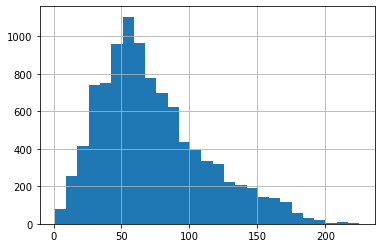

In [12]:
word.hist(bins=27);

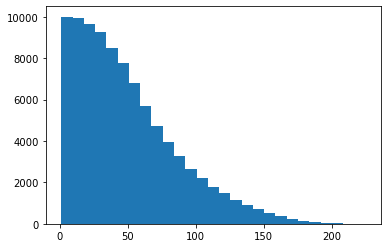

In [13]:
plt.hist(x = word, bins=27, cumulative=-1);

Interesting distribution. Does not appear Gaussian. I've read that Dirichlet distribution is best applied to corpi of vernacular text.

     semantics

This section is not 

In [14]:
# https://spacy.io/usage/processing-pipelines
space_case = spacy.load("en_core_web_sm", disable=["parser", "ner", "textcat"])

In [15]:
précis = space_case(arxiv_meta["abstract_processed_text"].iloc[1])
précis

new algorithm pebble game colors use obtain characterization family sparse graphs algorithmic solutions family problems concerning tree decompositions graphs special instances sparse graphs appear rigidity theory received increased attention recent years particular colored pebbles generalize strengthen previous results lee streinu new proof tutte nash williams characterization arboricity present new decomposition certifies sparsity based pebble game colors work exposes connections pebble game algorithms previous sparse graph algorithms gabow gabow westermann hendrickson

In [16]:
[print(token, token.tag_) for token in précis[0:10]];

new JJ
algorithm NNP
pebble JJ
game NN
colors NNS
use VBP
obtain VB
characterization NN
family NN
sparse NN


In [17]:
[print(token, token.pos_) for token in précis[0:10]];

new ADJ
algorithm PROPN
pebble ADJ
game NOUN
colors NOUN
use VERB
obtain VERB
characterization NOUN
family NOUN
sparse NOUN


In [18]:
[print(token, token.lemma_) for token in précis[0:10]];

new new
algorithm algorithm
pebble pebble
game game
colors color
use use
obtain obtain
characterization characterization
family family
sparse sparse


POS tags are not utilized in any model or embedding. Left here as an exploration of an option for future lda2vec implementation.

In [19]:
# parse = spacy.load("en_core_web_sm")
# display = parse(arxiv_meta["abstract"].iloc[1])

# # https://stackoverflow.com/questions/56181929/save-spacy-render-file-as-svg-using-displacy
# from pathlib import Path
# svg = displacy.render(display[38:46], style="dep", jupyter=False)
# output_path = Path("../images/sample_sentence_2.svg")
# output_path.open("w", encoding="utf-8").write(svg);

#### Topic Model n-grams(uni-grams)

In [20]:
# Gensim tutorial on LDA implementaion
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html

In [21]:
# lemmatize the text. Minimal contractions made
arxiv_meta["abstract_lemmatized_processed_text"] = lemmings(arxiv_meta, ["abstract_processed_text"])
arxiv_meta["abstract_lemmatized_processed_text"].to_csv("../data/transformed/abstract_lemmatized_processed_text.csv", index=False)

In [22]:
arxiv_meta["abstract_lemmatized_processed_text"] = pd.read_csv("../data/transformed/abstract_lemmatized_processed_text.csv")

In [23]:
# Tokenize text using gensim built in preprocessor. Checked documentation just uses RegExp
# with add deacc
abstract_tokens = [gensim.utils.simple_preprocess(x, deacc=True) for x in arxiv_meta["abstract_lemmatized_processed_text"]]

# Creates a dictionary {int_key : word_value}
word2id = gensim.corpora.Dictionary(abstract_tokens)
# ids of token/dict key with count of tokens in doc
# each doc becomes a bag of words
corpus = [word2id.doc2bow(x) for x in abstract_tokens]

In [24]:
# LDA model, alpha and (b)eta update every pass and are left to "auto". These define the prior and
# shape the probability distribution used to weigh doc and words topic composition.
# This is very technical model and deserves its own write up.
# Every document has a context, this context is modelled as a mixture of n topics. Every word "learns"
# a rank in topics those with high ranks per topics come to indicate that topic
lda = LdaModel(corpus=corpus, id2word=word2id,  num_topics=17, chunksize=500, passes=20,
               update_every=1, alpha="auto", eta="auto", random_state=137)

lda.save("../models/137_model.model")

In [25]:
doc_topic_mixture = list(lda.get_document_topics(corpus))[0]
doc_topic_mixture

[(2, 0.06153787),
 (6, 0.09562606),
 (9, 0.03896704),
 (11, 0.024808373),
 (14, 0.24180812),
 (15, 0.023457227),
 (16, 0.48759052)]

Doc 1 would be ascribed doc 16

    Visualize unigram topics

In [43]:
# Tea leaves
# https://proceedings.neurips.cc/paper/2009/file/f92586a25bb3145facd64ab20fd554ff-Paper.pdf

In [124]:
# https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
pyLDAvis.enable_notebook()
topics = pyLDAvis.gensim_models.prepare(lda, corpus, word2id, mds="mmds", R=20)
pyLDAvis.save_html(topics, "../topic_visualizations/second_attempt.html")
topics

C:\Users\mjwjl\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


    Metrics unigram topics

In [71]:
lda_coherence = CoherenceModel(model=lda, texts=abstract_tokens, dictionary=word2id, coherence="c_v")
lda_coherence_score = lda_coherence.get_coherence()
lda_coherence_score_per_topic = lda_coherence.get_coherence_per_topic()
for i in range(len(lda.get_topics())):
    print(f"Topic {i + 1} Coherence score: {lda_coherence_score_per_topic[i]}")

Topic 1 Coherence score: 0.4096498060640815
Topic 2 Coherence score: 0.3858960469222602
Topic 3 Coherence score: 0.42608087714716286
Topic 4 Coherence score: 0.5208597996990907
Topic 5 Coherence score: 0.3835958863495076
Topic 6 Coherence score: 0.5976483475510681
Topic 7 Coherence score: 0.4172492133610379
Topic 8 Coherence score: 0.4473155068391083
Topic 9 Coherence score: 0.3445044155180455
Topic 10 Coherence score: 0.5611621685533199
Topic 11 Coherence score: 0.3647008572776389
Topic 12 Coherence score: 0.5827546815862884
Topic 13 Coherence score: 0.40001414333699303
Topic 14 Coherence score: 0.3143982941840682
Topic 15 Coherence score: 0.41948615412295903
Topic 16 Coherence score: 0.39319362428539895
Topic 17 Coherence score: 0.4111234955772378
Topic 18 Coherence score: 0.47776663341597086
Topic 19 Coherence score: 0.40074256628406096
Topic 20 Coherence score: 0.4781823183311329
Topic 21 Coherence score: 0.3833919274346146
Topic 22 Coherence score: 0.3454272366021388
Topic 23 Cohe

    grid search

In [28]:
from modules.custom_grid_search import topic_num_search

In [30]:
# search = topic_num_search(tokens=abstract_tokens, corpus=corpus, id2word=word2id, min_topics=41, max_topics=100)

In [31]:
# with open("../models/topic_models/topic_coherence_scores_41_100.pkl", "wb") as file:
#     pickle.dump(search, file)

In [78]:
with open("../models/topic_models/topic_coherence_scores.pkl", "rb") as file:
    coherence_scores = pickle.load(file)

In [32]:
# with open("../models/topic_models/topic_coherence_scores_41_100.pkl", "rb") as file:
#     scores_41_100 = pickle.load(file)

In [70]:
# coherence_scores.extend(scores_41_100)

In [72]:
search_x = [coherence_scores[i][0] for i in range(len(search))]
search_y = [coherence_scores[i][2] for i in range(len(search))]

plt.figure(figsize=(16, 9))

#plt.plot(search[0], search[1], label="Coherence")
plt.plot(search_x, search_y, label="Coherence", color="#595959", linewidth=2.0)

plt.xlabel("No. of Topics", fontsize=22)
plt.xticks(fontsize=18)
plt.ylabel("Coherence Score", fontsize=22)
plt.yticks(fontsize=18)
plt.title("Coherence Scores for N Topics", fontsize=28)
plt.legend(prop={"size" : 14})
plt.savefig("../images/coherence_scores.png", transparent=True);

#### Topic Model n-gram(bigram & trigram)

In [114]:
# follow tutorial on how to build phrases(n-grams)
# https://radimrehurek.com/gensim/models/phrases.html
from gensim.models import phrases

In [115]:
bigram = phrases.Phrases(abstract_tokens, min_count=2, threshold=.25, max_vocab_size=27000)
trigram_bigram = phrases.Phrases(bigram[abstract_tokens], min_count = 2, threshold=.25, max_vocab_size=27000)

In [116]:
# https://stackoverflow.com/questions/46129335/get-bigrams-and-trigrams-in-word2vec-gensim
bi_tri_gram_tokens = phrases.Phraser(trigram_bigram)
#ngram_tokens.phrasegrams
ngram_tokens = [bi_tri_gram_tokens[x] for x in abstract_tokens]

In [117]:
ngram2id = gensim.corpora.Dictionary(ngram_tokens)
#ngram2id.filter_extremes(no_below=.025, no_above=.2)
ngram_corpus = [ngram2id.doc2bow(x) for x in ngram_tokens]
print(ngram2id)

Dictionary(24397 unique tokens: ['accuracy', 'anti', 'antiquark', 'calculation', 'cdf']...)


In [129]:
lda_ngram = LdaModel(corpus=ngram_corpus, num_topics=20, id2word=ngram2id, chunksize=500, passes=40,
               update_every=1, alpha="auto", eta="auto", random_state=137)

lda_ngram.save("../models/137_ngram_model.model")

In [130]:
# https://pyldavis.readthedocs.io/en/latest/modules/API.html#pyLDAvis.prepare
pyLDAvis.enable_notebook()
ngram_topics = pyLDAvis.gensim_models.prepare(lda_ngram, ngram_corpus, ngram2id, mds="mmds", R=20)
pyLDAvis.save_html(topics, "../visualizations/topic_visualizations/n_gram_137_LDAvis.html")
ngram_topics

C:\Users\mjwjl\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


In [121]:
lda_ngram.log_perplexity(ngram_corpus, total_docs=10000)

-9.939813645382408

In [126]:
ngram_lda_coherence = CoherenceModel(model=lda_ngram, texts=ngram_tokens, dictionary=ngram2id, coherence="c_v")
ngram_lda_coherence_score = ngram_lda_coherence.get_coherence()
ngram_lda_coherence_score_per_topic = ngram_lda_coherence.get_coherence_per_topic()
for i in range(len(lda_ngram.get_topics())):
    print(f"Overall Topic {i + 1} Coherence score: {ngram_lda_coherence_score}")
    print(f"Topic {i + 1} Coherence score: {ngram_lda_coherence_score_per_topic[i]}")

Overall Topic 1 Coherence score: 0.4966159940262078
Topic 1 Coherence score: 0.41636559428929
Overall Topic 2 Coherence score: 0.4966159940262078
Topic 2 Coherence score: 0.49200754852660733
Overall Topic 3 Coherence score: 0.4966159940262078
Topic 3 Coherence score: 0.4336441043858188
Overall Topic 4 Coherence score: 0.4966159940262078
Topic 4 Coherence score: 0.3950494530766847
Overall Topic 5 Coherence score: 0.4966159940262078
Topic 5 Coherence score: 0.6166678896854746
Overall Topic 6 Coherence score: 0.4966159940262078
Topic 6 Coherence score: 0.5464365181763836
Overall Topic 7 Coherence score: 0.4966159940262078
Topic 7 Coherence score: 0.3916802148698625
Overall Topic 8 Coherence score: 0.4966159940262078
Topic 8 Coherence score: 0.44280127304919253
Overall Topic 9 Coherence score: 0.4966159940262078
Topic 9 Coherence score: 0.40843689850153764
Overall Topic 10 Coherence score: 0.4966159940262078
Topic 10 Coherence score: 0.5661867148607498
Overall Topic 11 Coherence score: 0.4

#### Ensemble Topic Model

In [31]:
from gensim.models import EnsembleLda

In [47]:
# EnsembleLDA should stabilize results over random states. Does not work as intended
# Creating solution
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_ensemblelda.html
ensemble = EnsembleLda(corpus=corpus, num_topics=20, num_models=8, epsilon=.05, ensemble_workers=2, distance_workers=2, topic_model_class ="ldamulticore")

#### Topic Model Embedding (Lda2vec, LdaSeqModel)

In [73]:
from gensim.models import Doc2Vec, EnsembleLda, LdaSeqModel, Word2Vec, callbacks
import lda2vec

In [76]:
# https://stackoverflow.com/questions/54888490/gensim-word2vec-print-log-loss
# The documentation for gensim is hit or miss. In this case the implementation of callbacks is obfuscated
class callback(callbacks.CallbackAny2Vec):

    def __init__(self):
        self.epoch = 0
        self.loss_to_be_subbed = 0

    def on_epoch_end(self, model):
        loss = model.get_latest_training_loss()
        loss_now = loss - self.loss_to_be_subbed
        self.loss_to_be_subbed = loss
        print(f"Loss after epoch {self.epoch}: {loss_now}")
        self.epoch += 1

In [33]:
# w2v = Word2Vec(sentences=abstract_tokens, vector_size=200, alpha=0.02, window=15, min_count=5, workers=4, sg=1, max_vocab_size=25000, negative=5,
#          epochs=100, compute_loss=True, callbacks=[callback()])

In [34]:
# w2v.save("../models/first_w2v.model")

In [79]:
w2v.wv.most_similar("mass")

[('masse', 0.7267782092094421),
 ('massive', 0.5681566596031189),
 ('msun', 0.5426380038261414),
 ('luminosity', 0.5326485633850098),
 ('stellar', 0.5137531757354736),
 ('star', 0.4862370789051056),
 ('m_sun', 0.4816111624240875),
 ('abundance', 0.42901110649108887),
 ('galaxy', 0.4238625168800354),
 ('halo', 0.39548105001449585)]

In [81]:
w2v.wv.most_similar("quantum")

[('state', 0.571729838848114),
 ('qubit', 0.5424454808235168),
 ('classical', 0.5260770916938782),
 ('mechanic', 0.506135106086731),
 ('entanglement', 0.5007437467575073),
 ('hamiltonian', 0.4900425970554352),
 ('entangle', 0.48750919103622437),
 ('multiparty', 0.4538072347640991),
 ('spin', 0.4453708231449127),
 ('teleportation', 0.4329047203063965)]

Creating LDA2vec next week. Custom/expanded context vector needed for graph relations

In [ ]:
# model = lda2vec(n_words, max_length, n_hidden, counts)
# model.add_component(10000, 40, name='document id')
# model.fit(clean, components=[doc_ids])

#### Topic Model tSNE

Other algorithms to be explored